In [15]:
import torch
import sys
import torchvision.transforms as T
sys.path.append('../')
from modeling import build_fe_model, build_model
from config import cfg
from data import make_data_loader
from engine.inference import inference

In [2]:
config_file = '../configs/softmax_triplet_with_center.yml'
cfg.merge_from_file(config_file)
cfg.freeze()

with open(config_file, 'r') as cf:
    config_str = "\n" + cf.read()

In [3]:
train_loader, val_loader, num_query, num_classes = make_data_loader(cfg)

# Tạo mô hình mới có cùng kiến trúc với model2
fe_model = build_fe_model(cfg, num_classes)
# Tải trạng thái từ file đã lưu
fe_model.load_state_dict(torch.load('/home/21011492/ReID/reid-strong-baseline/output/market1501/feature_extraction_model_state.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fe_model.to(device)
# Bây giờ new_model2 có các tham số giống với model2 đã được lưu

=> Market1501 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
Loading pretrained ImageNet model......


FeatureExtraction(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ker

In [4]:
def extract_transforms(cfg, input_image):
    transform = T.Compose([
        T.Resize(cfg.INPUT.SIZE_TEST),
        T.ToTensor(),
        T.Normalize(mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD)
    ])
    return transform(input_image)

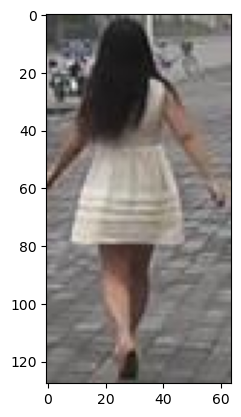

In [5]:
from PIL import Image
from matplotlib import pyplot as plt

# Specify the path to the image file
image_path = "/home/21011492/ReID/Datasets/market1501/query/0001_c1s1_001051_00.jpg"

# Open the image
image = Image.open(image_path)

plt.imshow(image)

In [6]:
transformed_image = extract_transforms(cfg, image)
transformed_image.shape

torch.Size([3, 256, 128])

In [7]:
# Preprocess the image
transformed_image = extract_transforms(cfg, image)

# Add a batch dimension to the image tensor
input_image = transformed_image.unsqueeze(0)

# Move the input tensor to the device (GPU if available)
input_image = input_image.to(device)

# Pass the input image through the model
output = fe_model(input_image)

# Print the output
print(output)


tensor([[0.0331, 0.2420, 0.1832,  ..., 0.0980, 0.1391, 0.0741]],
       grad_fn=<ViewBackward0>)


In [8]:
output.shape

torch.Size([1, 2048])

In [85]:
import os
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.transform = T.Compose([
            T.Resize(cfg.INPUT.SIZE_TEST),
            T.ToTensor(),
            T.Normalize(mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD)
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)

        # Extract label from the first 4 characters of the image name
        label = int(img_name.split(os.path.sep)[-1][:4])

        return image, label

In [ ]:
# Specify the path to the dataset
dataset_path = "/home/21011492/ReID/Datasets/dukemtmc/bounding_box_train"

# Create a CustomDataset instance
custom_dataset = CustomDataset(root_dir=dataset_path)

# Create a DataLoader for the dataset
batch_size = 1024
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

In [86]:
import torch
import pandas as pd

# Create empty lists to store the embeddings and labels
embedding_list = []
label_list = []

# Iterate over the batches of data
for batch_images, batch_labels in data_loader:
    # Move the batch of images to the device (GPU if available)
    batch_images = batch_images.to(device)
    
    # Pass the batch of images through the model
    output = fe_model(batch_images)
    
    # Split the output embeddings for each image in the batch
    embeddings = torch.split(output, 1)
    
    # Iterate over the embeddings and labels in the batch
    for embedding, label in zip(embeddings, batch_labels):
        # Convert the embedding tensor to a list of numbers
        embedding_list.append(embedding.squeeze().cpu().detach().numpy().tolist())
        label_list.append(label.item())


In [101]:
# Combine embeddings and labels into a list of lists
data = [embedding + [label] for embedding, label in zip(embedding_list, label_list)]

# Define column names
columns = [f"feature_{i}" for i in range(len(embedding_list[0]))] + ["Label"]

# Create DataFrame from the list of lists
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
df.to_csv('/home/21011492/ReID/reid-strong-baseline/embeddings.csv', index=False)

In [89]:
# Specify the path to the dataset
dataset_path2 = "/home/21011492/ReID/Datasets/dukemtmc/bounding_box_test"

# Create a CustomDataset instance
custom_dataset2 = CustomDataset(root_dir=dataset_path2)

# Create a DataLoader for the dataset
batch_size = 2048
data_loader2 = DataLoader(dataset=custom_dataset2, batch_size=batch_size, shuffle=True)

In [93]:
import torch
import pandas as pd

# Create empty lists to store the embeddings and labels
embedding_list2 = []
label_list2 = []

# Iterate over the batches of data
for batch_images, batch_labels in data_loader2:
    # Move the batch of images to the device (GPU if available)
    batch_images = batch_images.to(device)
    
    # Pass the batch of images through the model
    output = fe_model(batch_images)
    
    # Split the output embeddings for each image in the batch
    embeddings = torch.split(output, 1)
    
    # Iterate over the embeddings and labels in the batch
    for embedding, label in zip(embeddings, batch_labels):
        # Convert the embedding tensor to a list of numbers
        embedding_list2.append(embedding.squeeze().cpu().detach().numpy().tolist())
        label_list2.append(label.item())


In [96]:
# Combine embeddings and labels into a list of lists
data2 = [embedding + [label] for embedding, label in zip(embedding_list2, label_list2)]

# Define column names
columns2 = [f"feature_{i}" for i in range(len(embedding_list2[0]))] + ["Label"]

# Create DataFrame from the list of lists
df2 = pd.DataFrame(data2, columns=columns2)

# Save the DataFrame to a CSV file
df2.to_csv('/home/21011492/ReID/reid-strong-baseline/embeddings_test.csv', index=False)

In [103]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/home/21011492/ReID/reid-strong-baseline/embeddings.csv')

# Split the DataFrame into features (embeddings) and labels
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [108]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Read the CSV file into a pandas DataFrame
df_test = pd.read_csv('/home/21011492/ReID/reid-strong-baseline/embeddings_test.csv')

# Split the DataFrame into features (embeddings) and labels
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Ensure that X_test has the same format as X_train
# If X_train has more features, you can adjust X_test accordingly

# Use the trained KNN classifier to predict the labels for the test data
y_pred = knn.predict(X_test.values)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)


/home/21011492/anaconda3/envs/ReID_Server/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.897004699620633
